# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

/Users/gwungwun/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load data

data_train = pd.read_csv('data/Bikeshare_train.csv')
data_test = pd.read_csv('data/Bikeshare_test.csv')
data_train = data_train.drop('Unnamed: 0', 1)
data_test = data_test.drop('Unnamed: 0', 1)

data_train = pd.get_dummies(data_train, columns=['season', 'month', 'day_of_week', 'weather'])
data_train = data_train.drop(['season_4.0', 'month_12.0', 'day_of_week_6.0', 'weather_3.0'], 1)
data_test = pd.get_dummies(data_test, columns=['season', 'month', 'day_of_week', 'weather'])
data_test = data_test.drop(['season_4.0', 'month_12.0', 'day_of_week_6.0', 'weather_3.0'], 1)

cp = ['temp', 'atemp', 'humidity', 'windspeed']
cp_means = [data_train[v].mean() for v in cp]
cp_std = [data_train[v].std() for v in cp]
for i, v in enumerate(cp):
    data_train[v] = (data_train[v] - cp_means[i]) / cp_std[i]
    data_test[v] = (data_test[v] - cp_means[i]) / cp_std[i]

col_names = list(data_train.columns[7:]) + list(data_train.columns[:7])
all_predictors = col_names[:-1]
data_train = data_train[col_names]
data_test = data_test[col_names]

# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [3]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

In [4]:
# your code here
from sklearn.linear_model import LinearRegression

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

In [5]:
alphas = [10**i for i in range(-5, 6)]
k_list = np.arange(100, 401, 50)

for k in k_list:
    print("sample size = {}".format(k))
    X_subset, y_subset = sample(X_train, y_train, k)

    ridgeRegression = RidgeCV(alphas)
    results = ridgeRegression.fit(X_subset, y_subset)
    print("Ridge Regression")
    print('The training R^2 is {}.'.format(results.score(X_subset, y_subset)))
    print('The test R^2 is {}.'.format(results.score(X_test, y_test)))

    lassoRegression = LassoCV(alphas = alphas)
    results = lassoRegression.fit(X_subset, y_subset)
    print("Lasso Regression")
    print('The training R^2 is {}.'.format(results.score(X_subset, y_subset)))
    print('The test R^2 is {}.'.format(results.score(X_test, y_test)))

    X_train_ols = sm.add_constant(X_subset)
    X_test_ols = sm.add_constant(X_test)

    result = sm.OLS(y_subset, X_train_ols).fit()
    y_train_pred = result.predict(X_train_ols)
    y_test_pred = result.predict(X_test_ols)
    print("OLS Regression")
    print('The training R^2 is {}.'.format(r2_score(y_subset, y_train_pred)))
    print('The test R^2 is {}.'.format(r2_score(y_test, y_test_pred)))
    print("\n")

sample size = 100
Ridge Regression
The training R^2 is 0.5487638114006146.
The test R^2 is 0.23308797024238967.
Lasso Regression
The training R^2 is 0.44423979748156495.
The test R^2 is 0.2378555732472288.
OLS Regression
The training R^2 is 0.6447160745877005.
The test R^2 is 0.08481065944514987.


sample size = 150
Ridge Regression
The training R^2 is 0.6858922337727491.
The test R^2 is 0.04691866833550917.
Lasso Regression
The training R^2 is 0.672515729536495.
The test R^2 is 0.09335446962394656.
OLS Regression
The training R^2 is 0.6945494856754562.
The test R^2 is -0.02247531302239203.


sample size = 200
Ridge Regression
The training R^2 is 0.6669706605377367.
The test R^2 is 0.18462049353828747.
Lasso Regression
The training R^2 is 0.6572401273011117.
The test R^2 is 0.19806282313039147.
OLS Regression
The training R^2 is 0.6708368285566666.
The test R^2 is 0.16348450681791238.


sample size = 250
Ridge Regression
The training R^2 is 0.5848699457930921.
The test R^2 is 0.2391500

/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso Regression
The training R^2 is 0.5006177093247458.
The test R^2 is 0.24589972303538643.
OLS Regression
The training R^2 is 0.6083337181487707.
The test R^2 is 0.1795934000978262.


sample size = 300
Ridge Regression
The training R^2 is 0.6540900438797939.
The test R^2 is 0.25988125839260345.
Lasso Regression
The training R^2 is 0.6567686134284894.
The test R^2 is 0.2610185390505656.
OLS Regression
The training R^2 is 0.6571255605221005.
The test R^2 is 0.2590679149431747.


sample size = 350
Ridge Regression
The training R^2 is 0.6789896385622688.
The test R^2 is 0.1456366351123587.


/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso Regression
The training R^2 is 0.6828145806725451.
The test R^2 is 0.1275218208914921.
OLS Regression
The training R^2 is 0.6833367035077568.
The test R^2 is 0.11633721824508747.


sample size = 400
Ridge Regression
The training R^2 is 0.6293369239630187.
The test R^2 is 0.2033300626440505.
Lasso Regression
The training R^2 is 0.6328439671749055.
The test R^2 is 0.1838432044869256.
OLS Regression
The training R^2 is 0.6331391628852583.
The test R^2 is 0.1757654238785692.




/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [6]:
# Repeat for 10 random trials/splits

alphas = [10**i for i in range(-5, 6)]
k_list = np.arange(100, 401, 50)
repeat = 10

ridge_train = np.zeros([7, repeat])
ridge_test = np.zeros([7, repeat])
lasso_train = np.zeros([7, repeat])
lasso_test = np.zeros([7, repeat])
ols_train = np.zeros([7, repeat])
ols_test = np.zeros([7, repeat])

for i in range(repeat):
    for j in range(len(k_list)):
        X_subset, y_subset = sample(X_train, y_train, k_list[j])

        ridgeRegression = RidgeCV(alphas)
        results = ridgeRegression.fit(X_subset, y_subset)
        ridge_train[j, i] = results.score(X_subset, y_subset)
        ridge_test[j, i] = results.score(X_test, y_test)

        lassoRegression = LassoCV(alphas = alphas)
        results = lassoRegression.fit(X_subset, y_subset)
        lasso_train[j, i] = results.score(X_subset, y_subset)
        lasso_test[j, i] = results.score(X_test, y_test)

        X_train_ols = sm.add_constant(X_subset)
        X_test_ols = sm.add_constant(X_test)

        result = sm.OLS(y_subset, X_train_ols).fit()
        y_train_pred = result.predict(X_train_ols)
        y_test_pred = result.predict(X_test_ols)
        ols_train[j, i] = r2_score(y_subset, y_train_pred)
        ols_test[j, i] = r2_score(y_test, y_test_pred)
        

/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective di

/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective di

/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


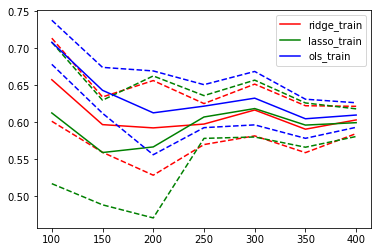

In [7]:
plt.plot(k_list, np.mean(ridge_train, axis = 1), 'r', label = "ridge_train")
plt.plot(k_list, np.mean(ridge_train, axis = 1) + np.std(ridge_train, axis = 1), 'r--')
plt.plot(k_list, np.mean(ridge_train, axis = 1) - np.std(ridge_train, axis = 1), 'r--')
plt.plot(k_list, np.mean(lasso_train, axis = 1), 'g', label = "lasso_train")
plt.plot(k_list, np.mean(lasso_train, axis = 1) + np.std(lasso_train, axis = 1), 'g--')
plt.plot(k_list, np.mean(lasso_train, axis = 1) - np.std(lasso_train, axis = 1), 'g--')

plt.plot(k_list, np.mean(ols_train, axis = 1), 'b', label = "ols_train")
plt.plot(k_list, np.mean(ols_train, axis = 1) + np.std(ols_train, axis = 1), 'b--')
plt.plot(k_list, np.mean(ols_train, axis = 1) - np.std(ols_train, axis = 1), 'b--')


plt.legend()

RuntimeError: xdata and ydata must be the same length

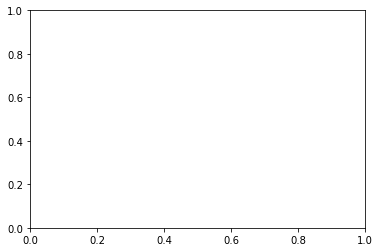

In [12]:
plt.errorbar(k_list, np.mean(ridge_test, axis = 1), np.std(ridge_test, axis = 1), 'r', label = "ridge_test")
# plt.plot(k_list, np.mean(ridge_test, axis = 1) + np.std(ridge_test, axis = 1), 'r--')
# plt.plot(k_list, np.mean(ridge_test, axis = 1) - np.std(ridge_test, axis = 1), 'r--')
# plt.plot(k_list, np.mean(lasso_test, axis = 1), 'g', label = "lasso_test")
# plt.plot(k_list, np.mean(lasso_test, axis = 1) + np.std(lasso_test, axis = 1), 'g--')
# plt.plot(k_list, np.mean(lasso_test, axis = 1) - np.std(lasso_test, axis = 1), 'g--')

# plt.plot(k_list, np.mean(ols_test, axis = 1), 'b', label = "ols_test")
# plt.plot(k_list, np.mean(ols_test, axis = 1) + np.std(ols_test, axis = 1), 'b--')
# plt.plot(k_list, np.mean(ols_test, axis = 1) - np.std(ols_test, axis = 1), 'b--')


plt.legend()

1. OLS regression has higher training $R^2$ but lower test score. This might be due to over-fitting, while Ridge regression and Lasso regression has its punished term to control this problem.
    
    When sample size increases, the performance of these three models almost converge.

2. The confidence interval narrows when sample size increases.

3. Choose Ridge regression or lasso regression for small sample size since they have larger test $R^2$.

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [9]:
def add_polynomial(X, order):
    X_new = X
    for i in range(2, order + 1):
        X_new = np.concatenate((X_new, X[:, -4:]**i), axis = 1)
        
    return X_new

In [10]:
X_train[:, -4:].shape

(331, 4)

In [11]:
# your code here
order = 4

x_order = add_polynomial(X_train, order)
x_order_test = add_polynomial(X_test, order)
    
x_order = sm.add_constant(x_order)
x_order_test = sm.add_constant(x_order_test)
regr_order = sm.OLS(y_train, x_order)
results = regr_order.fit()
print("training R^2 for order {} is {}".format(order, r2_score(y_train, results.predict(x_order))))
print("testing R^2 for order {} is {}".format(order, r2_score(y_test, results.predict(x_order_test))))

training R^2 for order 4 is 0.6696562402214015
testing R^2 for order 4 is 0.2772384350861521


The test $R^2$ is higher

In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     15.13
Date:                Sat, 07 Oct 2017   Prob (F-statistic):           7.98e-50
Time:                        15:38:10   Log-Likelihood:                -2790.9
No. Observations:                 331   AIC:                             5662.
Df Residuals:                     291   BIC:                             5814.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5429.9163    711.186      7.635      0.000    4030.197    6829.636
x1         -1523.2288    467.580     -3.258      0.001   -2443.496    -602.961
x2          -756.7981    536.808     -1.410      0.160   -1813.316     299.720
x3            55.5255    419.974      0.132      0.895    -771.046     882.097
x4           555.6676    479.543      1.159      0.248    -388.146    1499.481
x5           230.5990    478.558      0.482      0.630    -711.275    1172.473
x6           250.8185    472.431      0.531      0.596    -678.997    1180.634
x7           137.6431    605.236      0.227      0.820   -1053.552    1328.838
x8          -481.5367    647.272     -0.744      0.458   -1755.466     792.392
x9          -900.5181    648.671     -1.388      0.166   -2177.201     376.164
x10         -861.3206    653.672     -1.318      0.189   -2147.844     425.203
x11        -1160.2713    644.832     -1.799      0.073   -2429.397     108.854
x12         -517.7332    527.018     -0.982      0.327   -1554.984     519.518
x13         -370.2035    420.771     -0.880      0.380   -1198.343     457.936
x14         -269.8653    380.406     -0.709      0.479   -1018.560     478.830
x15         -471.0834    246.557     -1.911      0.057    -956.345      14.178
x16         -227.9217    157.372     -1.448      0.149    -537.653      81.809
x17         -268.0232    186.488     -1.437      0.152    -635.060      99.014
x18           13.1360    196.966      0.067      0.947    -374.522     400.794
x19         -104.0028    189.352     -0.549      0.583    -476.675     268.669
x20           75.3419    184.193      0.409      0.683    -287.178     437.861
x21         1043.9997    546.051      1.912      0.057     -30.710    2118.709
x22         1103.0116    499.023      2.210      0.028     120.859    2085.164
x23         -526.2557    372.773     -1.412      0.159   -1259.929     207.418
x24           14.7858    159.059      0.093      0.926    -298.265     327.837
x25          771.4866    760.117      1.015      0.311    -724.536    2267.510
x26          897.2756    713.172      1.258      0.209    -506.353    2300.904
x27         -668.9145    157.356     -4.251      0.000    -978.615    -359.214
x28         -446.5085    148.929     -2.998      0.003    -739.623    -153.394
x29        -1811.0180    816.910     -2.217      0.027   -3418.820    -203.216
x30         1175.5005    788.864      1.490      0.137    -377.102    2728.103
x31          -53.6709    155.383     -0.345      0.730    -359.488     252.146
x32          -34.1653    126.952     -0.269      0.788    -284.026     215.695
x33            8.6078    275.731      0.031      0.975    -534.071     551.287
x34         -303.9358    246.097     -1.235      0.218    -788.292     180.420
x35          -16.0576     44.892     -0.358      0.721    -104.412      72.297
x3

There are 6 significant predictors: const, season_1.0, weather 2.0, humidity, windspeed, temp^2

In [13]:
tmp = data_train['weather_1.0'] * data_train['workingday']
x_inter = np.concatenate((X_train, tmp.values.reshape(-1, 1)), axis = 1)
tmp_test = data_test['weather_1.0'] * data_test['workingday']
x_inter_test = np.concatenate((X_test, tmp_test.values.reshape(-1, 1)), axis = 1)

In [14]:
data_train_tmp = pd.read_csv('data/Bikeshare_train.csv')
data_test_tmp = pd.read_csv('data/Bikeshare_test.csv')
data_train_tmp = pd.get_dummies(data_train_tmp, columns=['month'])
data_test_tmp = pd.get_dummies(data_test_tmp, columns=['month'])

In [15]:
tmp = data_train_tmp['month_12.0'] * data_train['temp']
x_inter = np.concatenate((x_inter, tmp.values.reshape(-1, 1)), axis = 1)
tmp_test = data_test_tmp['month_12.0'] * data_test['temp']
x_inter_test = np.concatenate((x_inter_test, tmp_test.values.reshape(-1, 1)), axis = 1)

In [16]:
x_inter = sm.add_constant(x_inter)
x_inter_test = sm.add_constant(x_inter_test)
regr_order = sm.OLS(y_train, x_inter)
results = regr_order.fit()
print("training R^2 for order {} is {}".format(order, r2_score(y_train, results.predict(x_inter))))
print("testing R^2 for order {} is {}".format(order, r2_score(y_test, results.predict(x_inter_test))))

training R^2 for order 4 is 0.580381348480301
testing R^2 for order 4 is 0.2685181896268102


The test $R^2$ is higher

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     14.36
Date:                Sat, 07 Oct 2017   Prob (F-statistic):           2.43e-41
Time:                        15:38:10   Log-Likelihood:                -2830.5
No. Observations:                 331   AIC:                             5721.
Df Residuals:                     301   BIC:                             5835.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4734.0152    918.011      5.157      0.000    2927.483    6540.547
x1          -884.3187    550.763     -1.606      0.109   -1968.152     199.515
x2          -110.9431    587.150     -0.189      0.850   -1266.381    1044.495
x3           -75.5976    453.682     -0.167      0.868    -968.388     817.193
x4         -1211.6733   1040.400     -1.165      0.245   -3259.052     835.706
x5         -1095.9921   1020.067     -1.074      0.283   -3103.357     911.373
x6          -896.4352    975.450     -0.919      0.359   -2816.000    1023.129
x7          -705.5649    997.870     -0.707      0.480   -2669.249    1258.119
x8         -1011.9024   1004.051     -1.008      0.314   -2987.750     963.945
x9         -1737.2977    980.173     -1.772      0.077   -3666.157     191.562
x10        -2140.0440    941.775     -2.272      0.024   -3993.341    -286.747
x11        -1640.2677    934.999     -1.754      0.080   -3480.230     199.695
x12         -421.5095    838.850     -0.502      0.616   -2072.263    1229.244
x13         -290.2825    766.708     -0.379      0.705   -1799.069    1218.504
x14         -681.9367    777.020     -0.878      0.381   -2211.016     847.142
x15         -423.1840    269.763     -1.569      0.118    -954.044     107.676
x16         -272.5310    174.283     -1.564      0.119    -615.499      70.437
x17         -357.2100    206.132     -1.733      0.084    -762.851      48.431
x18           -7.7484    217.339     -0.036      0.972    -435.446     419.949
x19          -89.8205    211.342     -0.425      0.671    -505.716     326.075
x20          -43.0576    203.513     -0.212      0.833    -443.546     357.431
x21         1339.9147    590.803      2.268      0.024     177.287    2502.542
x22         1563.2213    477.700      3.272      0.001     623.167    2503.275
x23         -571.0206    406.951     -1.403      0.162   -1371.851     229.809
x24         -199.3469    265.959     -0.750      0.454    -722.720     324.027
x25          906.9589    475.169      1.909      0.057     -28.114    1842.032
x26          274.7706    429.787      0.639      0.523    -570.997    1120.538
x27         -574.1179    113.992     -5.036      0.000    -798.441    -349.795
x28         -275.7457     81.737     -3.374      0.001    -436.593    -114.898
x29          313.2194    352.789      0.888      0.375    -381.025    1007.464
x30         1045.1338    729.703      1.432      0.153    -390.832    2481.099
==============================================================================
Omnibus:                       33.048   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.362
Skew:                           0.037   Prob(JB):                      0.00562
Kurtosis:                       2.136   Cond. No.                     2.98e+15
==

There are 6 significant predictors: const, month_7.0, weather 1.0, weather 2.0, humidity, windspeed.

None of the interactive terms and their relative predictors are significant. The reason might be multi-colinearity.

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [18]:
def add_polynomial(X, order):
    X_new = X[:, -4:] ** 2
    for i in range(3, order + 1):
        X_new = np.concatenate((X_new, X[:, -4:]**i), axis = 1)
    return X_new

In [19]:
#your code here
interactive = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_train)
interactive = np.concatenate((interactive, add_polynomial(X_train, 4)), axis = 1)
interactive_test = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_test)
interactive_test = np.concatenate((interactive_test, add_polynomial(X_test, 4)), axis = 1)

In [20]:
interactive.shape

(331, 419)

Multi-linearity. Also the computation cost is too high.

In [21]:
from sklearn.preprocessing import normalize
interactive = normalize(interactive, axis= 0)
interactive_test = normalize(interactive_test, axis= 0)

In [22]:
from sklearn.decomposition import PCA
for i in range(1, 6):
    pca = PCA(n_components= i)
    pca.fit(interactive)
    x_train_pca = pca.transform(interactive)
    x_test_pca = pca.transform(interactive_test)
    x_train_pca = sm.add_constant(x_train_pca)
    x_test_pca = sm.add_constant(x_test_pca)
    result = sm.OLS(y_train, x_train_pca).fit()
    print(i)
    print(r2_score(y_train, result.predict(x_train_pca)))
    print(r2_score(y_test, result.predict(x_test_pca)))

1
0.346449011502
0.208711780599
2
0.348582194888
0.209250926546
3
0.368181260459
0.215809391337
4
0.380668864263
0.213844871712
5
0.381133501963
0.21220982517


We should normalize since we are comparing their ability to explain variety in the dataset. So we have to normalize, otherwise PCA can't select correct variables through unnormalized data.

As the increment of components, the training score increases.

The test score are worse than the previous models.
The coefficients refer to the increment of response as the combined predictors, which explain most of the variance ratio, increases 1 unit.

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [23]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [41]:
# your code here
result = sm.OLS(y_train, x_order).fit()
y_pred = result.predict(x_order)
y_pred[y_pred < -1] = 0
y_pred_test = result.predict(x_order_test)
y_pred_test[y_pred_test < -1] = 0
print("training RMSLE: {}" .format(rmsle(y_train, y_pred)))
print("testing RMSLE: {}" .format(rmsle(y_test, y_pred_test)))

training RMSLE: 0.7214576597005684
testing RMSLE: 0.8576183145361487


In [42]:
coeff0 = result.params

In [43]:
def loss_rmsle(coeff, X=x_order, y=y_train):
    y_pred = np.dot(X, coeff)
    y_pred[y_pred < -1] = 0
    return rmsle(y, y_pred)

In [44]:
from scipy.optimize import fmin
coeff1 = fmin(loss_rmsle, coeff0, maxiter=100000)

Gradient descent method using optimize.fmin function in scipy package to choose beta that minize the cost function.

In [45]:
loss_rmsle(coeff1, x_order_test, y_test)

0.85170554756544981

In [46]:
r2_score(y_test, np.dot(x_order_test, coeff1))

0.16140342401960106

rmsle score for new model is slightly lower.

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

In [47]:
# your code here
def loss_rmsle_thres(coeff, X=x_order, y=y_train, thres = 0.05):
    y_pred = np.dot(X, coeff)
    r = abs(y_pred - y)
    ind = np.argsort(r)[:(int)(len(r) * (1 - 0.05))]
    y_pred = y_pred[ind]
    y = y[ind]
    y_pred[y_pred < -1] = 0
    return rmsle(y, y_pred)

In [48]:
coeff2 = fmin(loss_rmsle_thres, coeff0, maxiter=100000)

Optimization terminated successfully.
         Current function value: 0.253879
         Iterations: 35066
         Function evaluations: 42211


In [49]:
r2_score(y_test, np.dot(x_order_test, coeff2))

0.28010031005526859

RMSLE in part (i) is worse than the previous model based on MSE, while RMSLE in this part is higher. That means MSE is relatively robust while RMSLE replies on the accuracy of data set. Another reason might be we replace the negative result to 0 so this process might loss some information. But when we deal with the error part, the optimization of RMSLE helps us to find better coefficients.

---
--_

# APCOMP209a - Homework Question



##  Question 1: Student's t MLE

Use Maximum Likelihood Estimation to generate a linear regression model on the data provided in ``beerdata.csv`` considering two statistical models for noise: a) iid Normal and b) iid Student's t-distribution with $\nu=5$ and scale factor σ=0.5.  

Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal? 





HINTS:
1. Use the probability density function for the Student's t distribution  with location μ and scale factor σ.
2. If the MLE regressions coefficients can not be derived analytically consider numerical methods.
3. You can use sklearn or statsmodel for the Normal case 




In [51]:
data = pd.read_csv('data/beerdata.csv')

## Question 2 (continued from HW2) 

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [13]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

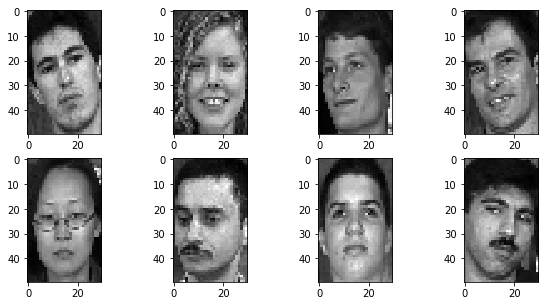

In [15]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()

In [16]:
train_dataset

array([[[  89.619,   85.858,   74.808, ...,   49.004,   50.847,   53.847],
        [  99.217,   96.836,   27.981, ...,   45.118,   49.075,   47.847],
        [  95.292,   35.943,   23.039, ...,   38.075,   48.217,   43.157],
        ..., 
        [  58.116,   59.757,   65.176, ...,  157.333,  159.735,  137.963],
        [  64.116,   53.757,   66.817, ...,  161.273,  157.974,  142.963],
        [  56.116,   52.757,   73.273, ...,  169.273,  169.974,  134.963]],

       [[  44.716,   63.716,   68.83 , ...,   29.171,   28.943,   30.242],
        [  51.716,   58.118,   61.759, ...,   39.285,   29.943,   35.943],
        [  71.716,   60.759,   65.275, ...,   35.605,   31.932,   36.943],
        ..., 
        [  35.943,   58.302,   73.096, ...,   48.915,   53.932,   68.074],
        [  52.16 ,   35.16 ,   39.943, ...,   35.687,   68.302,   60.704],
        [  45.16 ,   35.16 ,   40.943, ...,   38.687,   67.302,   54.704]],

       [[  56.256,   50.174,   61.217, ...,   39.726,   41.036,   43